# Importing Libraries

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

#Importing necessary libraries
from glob import glob
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image
from sklearn.utils import class_weight

# EDA

In [38]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [3]:
#Path
picture_size = 48
folder_path = r"C:\Users\dogsh\OneDrive\Dokument\DeepLearning\Emotion_Detection_CNN-main\images"

In [4]:
training_dir = os.path.join(folder_path, "train")
print("Training Directory:", training_dir)
print("Contents of Training Directory:", os.listdir(training_dir))

Training Directory: C:\Users\dogsh\OneDrive\Dokument\DeepLearning\Emotion_Detection_CNN-main\images\train
Contents of Training Directory: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
data = []

for emotion in emotions:
    emotion_dir = os.path.join(training_dir, emotion)
    print(f"Checking directory for emotion '{emotion}': {emotion_dir}")

    if os.path.exists(emotion_dir):
        files = os.listdir(emotion_dir)
        print(f"Contents of {emotion} directory: {files}")
        for img in files:
            img_path = os.path.join(emotion_dir, img)
            data.append([img_path, emotion])
            print(f"Added image: {img_path} with emotion: {emotion}")
    else:
        print(f"Directory for emotion '{emotion}' does not exist.")

df = pd.DataFrame(data, columns=['image_path', 'emotion'])
print(df.head())

In [ ]:
print(df.head)

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  28821 non-null  object
 1   emotion     28821 non-null  object
dtypes: object(2)
memory usage: 450.5+ KB
None


In [8]:
print(df['emotion'].value_counts())

happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: emotion, dtype: int64


# Displaying Images

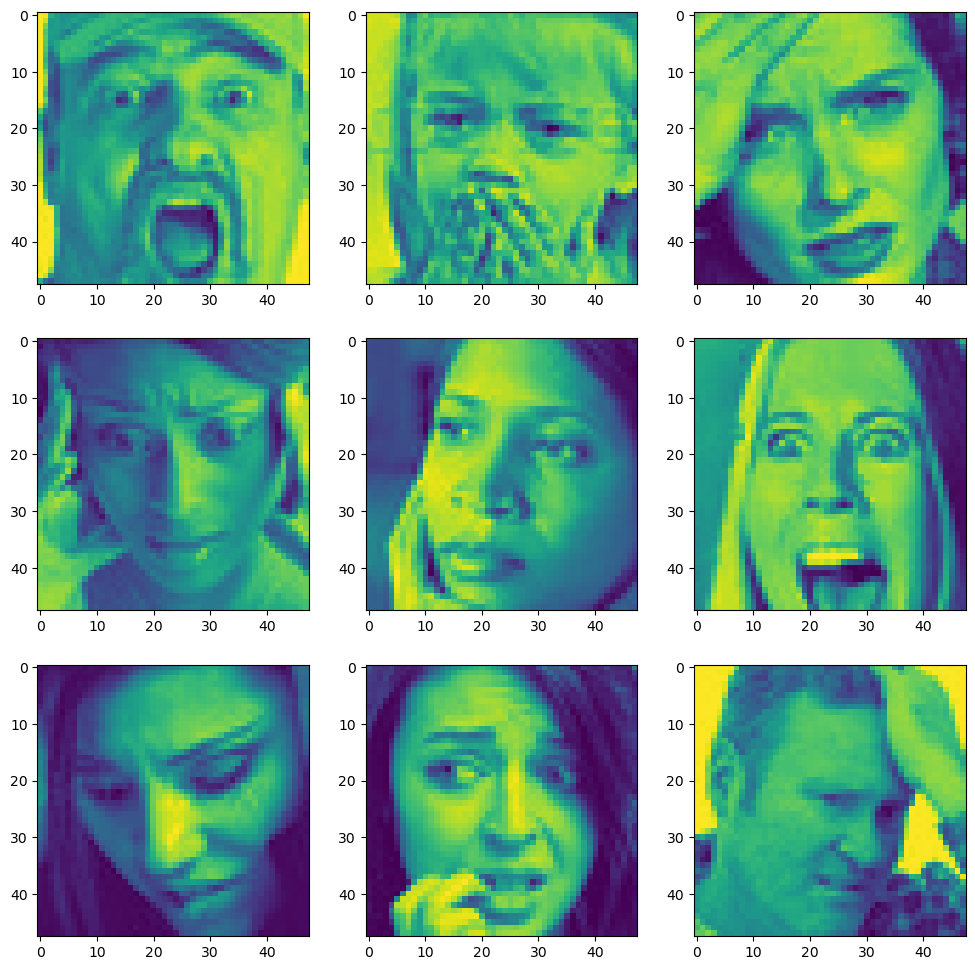

In [9]:
#Displaying 9 images from a folder
expression = 'fear'

plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img_name = os.listdir(os.path.join(folder_path, "train", expression))[i]
    img_path = os.path.join(folder_path, "train", expression, img_name)
    img = Image.open(img_path)
    img = img.resize((picture_size, picture_size))  # Resize image
    plt.imshow(img)
plt.show()

# Making Training and Validation Data

In [10]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()
#Load training dataset
train_set = datagen_train.flow_from_directory(folder_path+r"\train",
    target_size = (picture_size,picture_size),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

#Load testing dataset
test_set = datagen_val.flow_from_directory(folder_path+r"\validation",
    target_size = (picture_size,picture_size),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [32]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected layer
model.add(Dense(512,activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(no_of_classes, activation='softmax'))

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

class_weights = {i : class_weights[i] for i in range(len(class_weights))}

#opt = Adam(learning_rate = 0.001)
#model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

# Fitting the Model with Training and Validation Data 

In [33]:
#ModelCheckpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("./model.keras",
    monitor='val_accuracy',
    verbose=1, 
    save_best_only=True, 
    mode='max')

#EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
                          )
#ReduceOnPlateau to reduce learning rate when validation loss plateau
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_delta=0.0001)
#Callback list
callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48
#Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
#Traning model
history = model.fit(train_set,
    steps_per_epoch=train_set.n//train_set.batch_size,
    epochs=epochs,
    validation_data = test_set,
    validation_steps = test_set.n//test_set.batch_size,
    callbacks=callbacks_list
                                )

# Plotting Accuracy & Loss

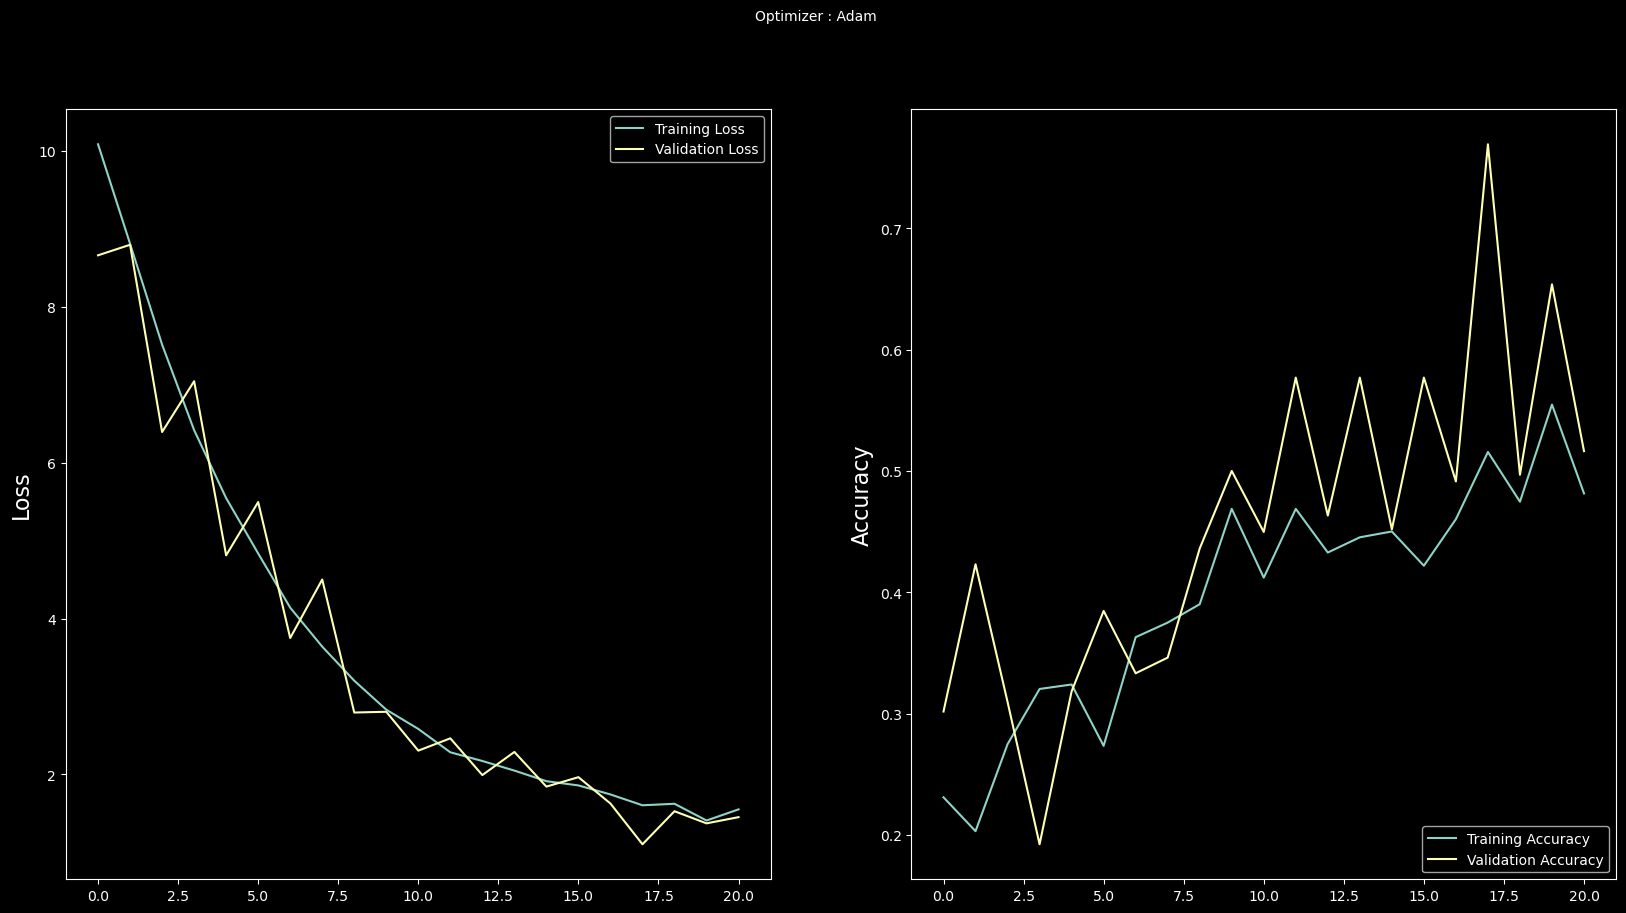

In [35]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [37]:
# Load the best model weights
model.load_weights('model_file.keras')
print(f"Loaded Model: {model}")


# evaluate the model with the best weights
score = model.evaluate(test_set, verbose=0)
print(f'Validation loss: {score[0]}')
print(f'Validation accuracy: {score[1]}')

Loaded Model: <Sequential name=sequential_5, built=True>
Validation loss: 1.6219358444213867
Validation accuracy: 0.49207472801208496


In [36]:
#model.save('model_file.keras')